# Tweet Sentiment Analysis
---

In [326]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import os

#Import WordCloud
from wordcloud import WordCloud, STOPWORDS
from scipy import stats

In [105]:
# Remove unwanted patterns
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from bs4 import BeautifulSoup

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chiehhsi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/chiehhsi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [106]:
#Model Selection and Validation
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

#from sklearn.cross_validation import StratifiedKFold, KFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, learning_curve

In [1716]:
def load_csv(filename):
    xls = pd.ExcelFile(filename)
    df1 = pd.read_excel(xls, 'Obama')
    df2 = pd.read_excel(xls, 'Romney')
    return df1, df2

def data_parse(df):
    
    #drop missing values and rename columns
    df = df.iloc[1:, 3:5]
    df = df.rename(columns = {'Anootated tweet':'Tweet', 'Unnamed: 4': 'Class'})
    # Drop rows if Tweet is empty
    df.dropna(subset = ['Tweet'], inplace=True)
    print(df.shape)
    
    #dtype class label
    df['Class'] = df['Class'].astype(str)
    df['Tweet'] = df['Tweet'].astype(str)
    print(df.info())
    print(df['Class'].value_counts())

    # Extract rows where class labels -1, 0, 1
    df = df[ (df['Class'] == '0') |(df['Class'] == '-1') | (df['Class'] == '1') ]
    print('After extracting:', df.shape)
    
    tweets = df['Tweet'].values
    targets = df['Class'].values
    
    return df

In [1702]:
# Tweet Cleaner
stopwordlist = set(stopwords.words("english"))
wordnet_lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()

def remove_specialchar(tweet):
    #Converts HTML tags to the characters they represent
    soup = BeautifulSoup(tweet, "html.parser")
    tweet = soup.get_text()
    
    #Convert www.* or https?://* to empty strings
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',tweet) 
    #Convert @username to empty strings
    tweet = re.sub('@[^\s]+','',tweet)

    #Remove additional white spaces
    tweet = re.sub('[\s]+', ' ', tweet)
    tweet = re.sub('[\n]+', ' ', tweet)
    
    #Replace #word with word
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    
    #Trims the tweet
    tweet = tweet.strip('\'"')
    
    #Remove all char not alphabets, num or whitespaces
    tweet = re.sub('[^A-Za-z0-9 ]+','', tweet)
    
    # Match all digits in the string and replace them by empty string
    pattern = r'[0-9]'
    tweet = re.sub(pattern, '', tweet)
    
    return tweet

#Replace words in abbr_dict, short_word_dict
def replace_words(s, words=abbr_dict):
    for k, v in words.items():
        s = s.replace(k, v)
    return s

def remove_stopwords(tweet):
    new_tweet = [w for w in tweet.split() if not w in stopwordlist] 
    return (" ").join(new_tweet) 

#Attempts to replace every individual word with it's root word.
def stemmer_lemmatizer(tweet):
    word_list = []
    for word in tweet.split():
        word = ps.stem(word)
        #word = wordnet_lemmatizer.lemmatize(word)
        word_list.append(word)
    return (" ".join(word_list))

#for testing
#Tweets = df_oba['Tweet'].values
#for i in range(len(Tweets)):
#    print(i)
#    b = remove_specialchar(Tweets[i])
#    a = stemmer_lemmatizer(b)
#    print('last', a)
#    print('last', remove_stopwords(a))


In [1703]:
def tweet_cleaning(tweets, flag):
    
    for i in range(len(tweets)):
        tweets[i] = tweets[i].lower()
        replace_words(tweets[i])
        tweets[i] = remove_specialchar(tweets[i])
        
        if flag == 'stem_lem':
            tweets[i] = stemmer_lemmatizer(tweets[i])
        if flag == 'rm_stopwords':
            tweets[i] = remove_stopwords(tweets[i])
        if flag == 'all':
            tmp = stemmer_lemmatizer(tweets[i])
            tweets[i] = remove_stopwords(tmp)
    return tweets

In [1701]:
import ast
f = open("abbr_dict.txt", "r")
contents = f.read()

abbr_dict = ast.literal_eval(contents)

In [1686]:
tweets_oba[10]

'obama prioriti k gaydar research secur embassi libya tlot tcot p'

In [1718]:
def save_dataset(tweets, targets, tw_name, tar_name, filepath = 'TrainData'):
    print('Saving training dataset...')
    
    #Create Saving Files
    if not os.path.exists(filepath):
        os.makedirs(filepath)
        
    np.save(filepath + '/' + tw_name + '.npy', tweets)
    np.save(filepath + '/'+ tar_name + '.npy', targets)

    print('Saved parsed dataset')
    

In [1201]:
def wordcloud(data,backgroundcolor = 'white', width = 400, height = 150):
    wordcloud = WordCloud(stopwords = STOPWORDS, background_color = backgroundcolor,
                         width = width, height = height).generate(data)
    plt.figure(figsize = (15, 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

In [1714]:
#Load dataset from .csv
df1, df2 = load_csv('training-Obama-Romney-tweets.xlsx')

## Obama's Tweets

In [1715]:
data_oba = data_parse(df1)

tweets_oba = data_oba['Tweet'].values
targets_oba = data_oba['Class'].values
tweets_oba.shape, targets_oba.shape

(7196, 2)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7196 entries, 1 to 7198
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweet   7196 non-null   object
 1   Class   7196 non-null   object
dtypes: object(2)
memory usage: 168.7+ KB
None
0             1977
-1            1968
1             1679
2             1543
irrevelant      23
nan              5
irrelevant       1
Name: Class, dtype: int64
After extracting: (5624, 2)


((5624,), (5624,))

In [1689]:
pd.DataFrame(targets_oba).value_counts().sort_index()

-1    1968
0     1977
1     1679
dtype: int64

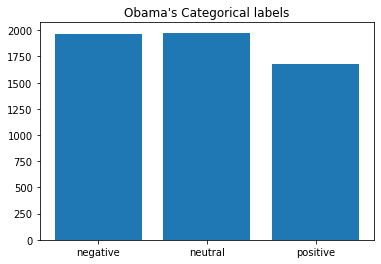

In [1690]:
# Bar Chart for train_labels
labels = ['negative', 'neutral', 'positive']
values = pd.DataFrame(targets_oba).value_counts().sort_index()
plt.bar(labels, values)
plt.title('Obama\'s Categorical labels')
plt.show()

In [1700]:
tweets_oba

array(["Kirkpatrick, who wore a baseball cap embroidered with Barack Obama's signature and had the hangdog look of Jason segel - Courier Journal",
       '#<e>obama</e> debates that Cracker Ass Cracker tonight... I will be tuned in! #TeamObama',
       '@Hollivan @hereistheanswer  Youre missing the point  Im afraid you do not understand the bigger picture if you dont care if Obama re elected',
       ...,
       ' The Reason <e>Ann Romney</e> And <e>Michelle Obama</e> Matched <a>Last Night</a>: <e>Michelle Obama</e> and <e>Ann Romney</e> showed up to last nig... http://t.co/lRXmH4Ka                           ',
       ' <e>Obama</e> Kenakan Cincin Syahadat Sejak SMA? http://t.co/HQw4rfqx                           ',
       ' Bitches be like "Obama<3" bitches just want <a>food stamps</a> lmao _Ù÷â                           '],
      dtype=object)

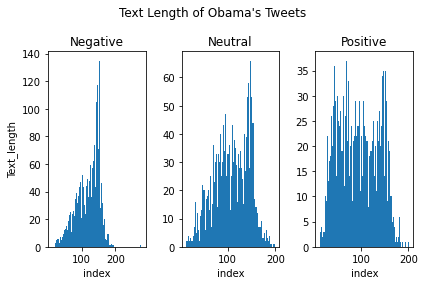

In [1692]:
# Bar plot for length of the input
fig = plt.figure()
fig.suptitle('Text Length of Obama\'s Tweets')
ax = fig.add_subplot(1, 3, 1)
ax.hist(data_oba[data_oba['Class']=='-1']['Tweet'].apply(lambda x: len(x)), bins=100)
ax.set_title("Negative")
ax.set_xlabel("index")
ax.set_ylabel("Text_length")

ax = fig.add_subplot(1, 3, 2)
ax.hist(data_oba[data_oba['Class']=='0']['Tweet'].apply(lambda x: len(x)), bins=100)
ax.set_title("Neutral")
ax.set_xlabel("index")
#ax.set_ylabel("Text_length")

ax = fig.add_subplot(1, 3, 3)
ax.hist(data_oba[data_oba['Class']=='1']['Tweet'].apply(lambda x: len(x)), bins=100)
ax.set_title("Positive")
ax.set_xlabel("index")
#ax.set_ylabel("Text_length")

plt.tight_layout()
plt.show()

In [1693]:
def print_commonWords(pDF, string):
    temp_df = pDF.copy()
    temp_df.loc[:, 'Tweet'] = temp_df.loc[:, 'Tweet'].apply(lambda x:str(x).split())
    top = Counter([item for sublist in temp_df['Tweet'] for item in sublist])
    temp = pd.DataFrame(top.most_common(20))
    temp.columns = ['words','count']
    temp.style.background_gradient(cmap='Blues')
    fig = px.bar(temp, x="count", y="words", title= ' Top 20 Commmon Words - '+ string, orientation='h', 
                 width=700, height=700,color='words')
    fig.show()

In [1694]:
def df_clean(df):
    for index, row in df.iterrows():
        tmp = row['Tweet']
        tmp = tmp.lower()
        replace_words(tmp)
        tmp = remove_specialchar(tmp)
        tmp = stemmer_lemmatizer(tmp)
        row['Tweet'] = remove_stopwords(tmp)
        
    return df

In [1695]:
from collections import Counter
import plotly.express as px

## Common Words for Oba_tweet

In [1696]:
# Print top 20 common words for original tweets
print_commonWords(data_oba, 'Original Obama\'s Tweets')

In [1697]:
# Print top 20 common words after clean obama tweets
clean_oba = df_clean(data_oba)
print_commonWords(clean_oba, 'Clean Obama\'s Tweets')

In [1305]:
# Print top 20 common words in Positive Tweets
df_pos = clean_oba[clean_oba['Class']== '1'].copy()
print_commonWords(df_pos, 'Obama\'s Positive Tweets')

In [1306]:
# Print top 20 common words in Neutral Tweets
df_neu = clean_oba[clean_oba['Class']== '0'].copy()
print_commonWords(df_neu, 'Obama\'s Neutral Tweets')

In [1307]:
# Print top 20 common words in Negative Tweets
df_neg = clean_oba[clean_oba['Class']== '-1'].copy()
print_commonWords(df_neg, 'Obama\'s Negative Tweets')

In [1698]:
oba_cleanall = tweet_cleaning(tweets_oba, 'all')
oba_cleanall[:10]

array(['kirkpatrick wore baseb cap embroid barack obama signatur hangdog look jason segel courier journal',
       'obama debat cracker ass cracker tonight tune teamobama',
       'miss point im afraid understand bigger pictur dont care obama elect',
       'wa rai democrat left parti year ago lifetim never seen presid divid countri like obama',
       'obama camp cant afford lower expect tonight debat presid must give strong perform',
       'obama pot polici disappoint say least legaizeit via',
       'hollywood ha hi back rt gene simmon yank obama support call pisspoor presid',
       'obama expedi speak fair order slender biscuittaiwan tension gjn',
       'dream wa smoke obama oo',
       'washington time presid popular bubbl ha burst barack obama fox nation obama ofa tcot'],
      dtype=object)

In [1475]:
oba_cleanall.shape, targets_oba.shape

((5624,), (5624,))

In [1477]:
#save_dataset(oba_cleanall, targets_oba, 'tweets_oba', 'targets_oba')

Saving training dataset...
Saved parsed dataset


## Romney's Tweets

In [1453]:
data_rom = data_parse(df2)

tweets_rom = data_rom['Tweet'].values
targets_rom = data_rom['Class'].values
tweets_rom.shape, targets_rom.shape

(7200, 2)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7200 entries, 1 to 7200
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweet   7200 non-null   object
 1   Class   7200 non-null   object
dtypes: object(2)
memory usage: 168.8+ KB
None
-1      2893
0       1680
2       1351
1       1075
!!!!     169
nan       29
IR         3
Name: Class, dtype: int64
After extracting: (5648, 2)


((5648,), (5648,))

In [1454]:
pd.DataFrame(targets_rom).value_counts().sort_index()

-1    2893
0     1680
1     1075
dtype: int64

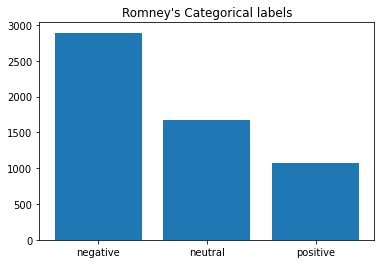

In [1455]:
# Bar Chart for train_labels
labels = ['negative', 'neutral', 'positive']
values = pd.DataFrame(targets_rom).value_counts().sort_index()
plt.bar(labels, values)
plt.title('Romney\'s Categorical labels')
plt.show()

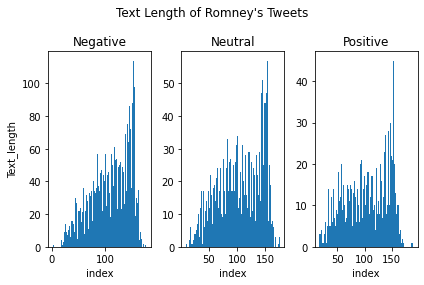

In [1456]:
fig = plt.figure()

fig.suptitle('Text Length of Romney\'s Tweets')

ax = fig.add_subplot(1, 3, 1)
ax.hist(data_rom[data_rom['Class']=='-1']['Tweet'].apply(lambda x: len(x)), bins=100)
ax.set_title("Negative")
ax.set_xlabel("index")
ax.set_ylabel("Text_length")

ax = fig.add_subplot(1, 3, 2)
ax.hist(data_rom[data_rom['Class']=='0']['Tweet'].apply(lambda x: len(x)), bins=100)
ax.set_title("Neutral")
ax.set_xlabel("index")
#ax.set_ylabel("Text_length")

ax = fig.add_subplot(1, 3, 3)
ax.hist(data_rom[data_rom['Class']=='1']['Tweet'].apply(lambda x: len(x)), bins=100)
ax.set_title("Positive")
ax.set_xlabel("index")
#ax.set_ylabel("Text_length")

plt.tight_layout()
plt.show()

In [1457]:
tweets_rom

array(["Insidious!<e>Mitt Romney</e>'s Bain Helped Philip Morris Get U.S. High Schoolers <a>Hooked On Cigarettes</a> http://t.co/nMKuFcUq via @HuffPostPol",
       '.@WardBrenda @shortwave8669 @allanbourdius you mean like <e>romney </e><a>cheated in primary</a>?',
       "<e>Mitt Romney</e> still doesn't <a>believe</a> that we <a>have a black president</a>.",
       ...,
       'el 59 por ciento de las mujeres blancas casadas respaldan a <e>Romney</e>"""',
       '"And they brought us a whole binder of women"""" oh <e>Romney</e>"""',
       '@FoxNews <e>Romney</e>won"""'], dtype=object)

## Common Words for Rom_tweet

In [1316]:
# Print top 20 common words for original tweets
print_commonWords(data_rom, 'Original Romney\'s Tweets')

In [1317]:
# Print top 20 common words after clean romney tweets
clean_rom = df_clean(data_rom)
print_commonWords(clean_rom, 'Clean Romney\'s Tweets')

In [1318]:
# Print top 20 common words in Positive Tweets
df_pos = clean_rom[clean_rom['Class']== '1'].copy()
print_commonWords(df_pos, 'Romney\'s Positive Tweets')

In [1319]:
# Print top 20 common words in Neutral Tweets
df_neu = clean_rom[clean_rom['Class']== '0'].copy()
print_commonWords(df_neu, 'Romney\'s Neutral Tweets')

In [1320]:
# Print top 20 common words in Negative Tweets
df_neg = clean_rom[clean_rom['Class']== '-1'].copy()
print_commonWords(df_neg, 'Romney\'s Negative Tweets')

In [1472]:
rom_cleanall = tweet_cleaning(tweets_rom, 'all')
rom_cleanall[:10]

array(['insidiousmitt romney bain help philip morri get us high schooler hook cigarett via',
       'mean like romney cheat primari',
       'mitt romney still doesnt believ black presid',
       'romney tax plan deserv nd look becaus ha secret one differ one lie',
       'hope romney debat prep w peopl last time',
       'want know mitt romney go abl cut trillon dollar go explain everyth',
       'romney win presidenti elect world realli end thi year',
       'romney million job scam remind rip torn sell penni movi sick puppi',
       'mitt romney said catch osama bin laden would insignific worth move heaven earth',
       'pleas mitt romney honey boo boo endors presid video'],
      dtype=object)

In [1474]:
rom_cleanall.shape, targets_rom.shape

((5648,), (5648,))

In [1476]:
#save_dataset(rom_cleanall, targets_rom, 'tweets_rom', 'targets_rom')

Saving training dataset...
Saved parsed dataset


## Data Preparation

In [1478]:
#Split tweets datasets
train_oba_X, val_oba_X, train_oba_Y, val_oba_Y = train_test_split(oba_cleanall, targets_oba, test_size = 0.2, random_state = 2018)

In [1479]:
train_rom_X, val_rom_X, train_rom_Y, val_rom_Y = train_test_split(rom_cleanall, targets_rom, test_size = 0.2, random_state = 2018)

In [1480]:
# Combine obama, Romney dataset with shuffle ordering
data_all = np.concatenate((oba_cleanall, rom_cleanall))
targets_all = np.concatenate((targets_oba, targets_rom))
data_all.shape, targets_all.shape

((11272,), (11272,))

In [1238]:
data_all[0], targets_all[0]

('kirkpatrick wore baseb cap embroid barack obama signatur hangdog look jason segel courier journal',
 '0')

In [1239]:
import random
tmp = list(zip(data_all, targets_all))
random.shuffle(tmp)
data_all, targets_all = zip(*tmp)
data_all[0], targets_all[0]

('im cathol support obama becau care futur racist obama black good person',
 '1')

In [1240]:
#save_dataset(data_all, targets_all, 'data_all', 'targets_all')

Saving training dataset...
Saved parsed dataset


In [1241]:
train_X, val_X, train_Y, val_Y = train_test_split(data_all, targets_all, test_size = 0.2, random_state = 2018)

In [657]:
def plot_cm(test_Y, pred_Y):
    labels = ['-1', '0', '1']
    cont_matrix = confusion_matrix(test_Y, pred_Y)
    ax = sns.heatmap(cont_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
 
    ax.set(ylabel="Actual", xlabel="Predicted")
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()
    

In [666]:
from sklearn.feature_extraction.text import TfidfTransformer

In [1496]:
def word2vec(train_X, val_X):
    vect = CountVectorizer(min_df=3, max_df=0.9)
    # learn training data vocabulary, then use it to create a document-term matrix
    X_train_dtm = vect.fit_transform(train_X)
    X_val_dtm = vect.transform(val_X)

    tfidf_transformer = TfidfTransformer()
    tfidf_transformer.fit(X_train_dtm)
    tfidf_transformer.transform(X_val_dtm)
    
    return X_train_dtm, X_val_dtm

In [680]:
word2vec(train_X, val_X)

(<9017x6492 sparse matrix of type '<class 'numpy.int64'>'
 	with 97629 stored elements in Compressed Sparse Row format>,
 <2255x6492 sparse matrix of type '<class 'numpy.int64'>'
 	with 23219 stored elements in Compressed Sparse Row format>)

## Train Models

### SVC

In [1359]:
def define_pipe(model):
    pipe = Pipeline([('vect', CountVectorizer(min_df=3, max_df=0.9)), 
                 ('tfidf', TfidfTransformer()),  
                 ('model', model)])
    return pipe

### SVC Model

              precision    recall  f1-score   support

          -1       0.65      0.61      0.63       422
           0       0.53      0.55      0.54       383
           1       0.62      0.64      0.63       320

    accuracy                           0.60      1125
   macro avg       0.60      0.60      0.60      1125
weighted avg       0.60      0.60      0.60      1125



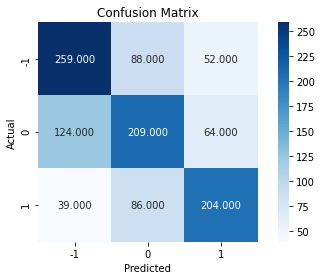

In [1481]:
# SVC with obama's tweets
pipe_SVC_o = define_pipe(SVC())
pipe_SVC_o.fit(train_oba_X, train_oba_Y)
y_pred_o = pipe_SVC_o.predict(val_oba_X)

print(classification_report(y_pred_o, val_oba_Y))
plot_cm(val_oba_Y, y_pred_o)

              precision    recall  f1-score   support

          -1       0.90      0.61      0.72       863
           0       0.27      0.51      0.35       171
           1       0.28      0.66      0.39        96

    accuracy                           0.60      1130
   macro avg       0.48      0.59      0.49      1130
weighted avg       0.75      0.60      0.64      1130



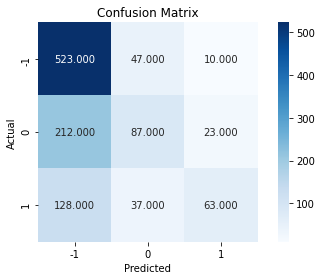

In [1482]:
# SVC with romney's tweets
pipe_SVC_r = define_pipe(SVC())
pipe_SVC_r.fit(train_rom_X, train_rom_Y)
y_pred_r = pipe_SVC_r.predict(val_rom_X)
print(classification_report(y_pred_r, val_rom_Y))
plot_cm(val_rom_Y, y_pred_r)

              precision    recall  f1-score   support

          -1       0.80      0.57      0.67      1296
           0       0.43      0.58      0.49       573
           1       0.44      0.62      0.51       386

    accuracy                           0.58      2255
   macro avg       0.56      0.59      0.56      2255
weighted avg       0.64      0.58      0.60      2255



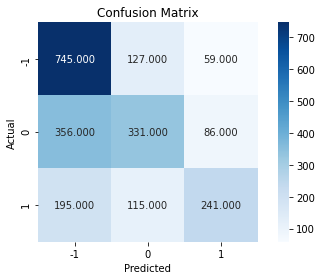

In [1483]:
#SVC with both rom and oba's tweets
pipe_SVC_a = define_pipe(SVC())
pipe_SVC_a.fit(train_X, train_Y)
y_pred_a = pipe_SVC_a.predict(val_X)
print(classification_report(y_pred_a,val_Y))
plot_cm(val_Y, y_pred_a)

## Model1 + Model2

In [1666]:
#Predict on Oba's data
pipe_SVC_oo = define_pipe(SVC())
pipe_SVC_oo.fit(train_oba_X, train_oba_Y)
y_pred_o = pipe_SVC_oo.predict(val_oba_X)

pipe_SVC_ro = define_pipe(SVC())
pipe_SVC_ro.fit(train_rom_X, train_rom_Y)
y_pred_r = pipe_SVC_ro.predict(val_oba_X)


print(y_pred_o[:10], y_pred_r[:10])

from operator import add
y_pred_o = [float(i) for i in y_pred_o]
y_pred_r = [float(i) for i in y_pred_r]
y_pred_o[:10], y_pred_r[:10]

#def avg(): 
y_avg = list(map(lambda x, y: (x + y)/2, y_pred_o, y_pred_r))
print(y_avg[:10])

y_avg = list(map(lambda x: -1 if x < 0 else (1 if x > 0 else 0), y_avg))
print(y_avg[:10])

y_avg = [str(int(i)) for i in y_avg]
print(y_avg[:10])

['-1' '1' '1' '1' '0' '-1' '1' '-1' '1' '0'] ['-1' '-1' '0' '-1' '0' '0' '-1' '-1' '-1' '0']
[-1.0, 0.0, 0.5, 0.0, 0.0, -0.5, 0.0, -1.0, 0.0, 0.0]
[-1, 0, 1, 0, 0, -1, 0, -1, 0, 0]
['-1', '0', '1', '0', '0', '-1', '0', '-1', '0', '0']


              precision    recall  f1-score   support

          -1       0.77      0.52      0.62       584
           0       0.40      0.46      0.42       344
           1       0.41      0.69      0.51       197

    accuracy                           0.53      1125
   macro avg       0.52      0.56      0.52      1125
weighted avg       0.59      0.53      0.54      1125



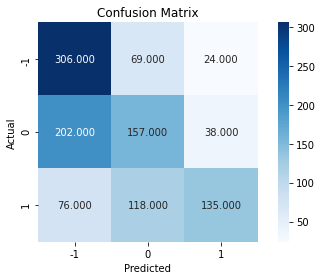

In [1667]:
print(classification_report(y_avg, val_oba_Y))
plot_cm(val_oba_Y, y_avg)

In [1668]:
#Predict on Rom's data
pipe_SVC_or = define_pipe(SVC())
pipe_SVC_or.fit(train_oba_X, train_oba_Y)
y_pred_o = pipe_SVC_or.predict(val_rom_X)

pipe_SVC_rr = define_pipe(SVC())
pipe_SVC_rr.fit(train_rom_X, train_rom_Y)
y_pred_r = pipe_SVC_rr.predict(val_rom_X)


print(y_pred_o[:10], y_pred_r[:10])

from operator import add
y_pred_o = [float(i) for i in y_pred_o]
y_pred_r = [float(i) for i in y_pred_r]
y_pred_o[:10], y_pred_r[:10]

#def avg(): 
y_avg = list(map(lambda x, y: (x + y)/2, y_pred_o, y_pred_r))
print(y_avg[:10])

y_avg = list(map(lambda x: -1 if x < 0 else (1 if x > 0 else 0), y_avg))
print(y_avg[:10])

y_avg = [str(int(i)) for i in y_avg]
print(y_avg[:10])

['0' '0' '0' '0' '0' '0' '0' '1' '-1' '0'] ['-1' '-1' '1' '0' '0' '-1' '0' '-1' '-1' '-1']
[-0.5, -0.5, 0.5, 0.0, 0.0, -0.5, 0.0, 0.0, -1.0, -0.5]
[-1, -1, 1, 0, 0, -1, 0, 0, -1, -1]
['-1', '-1', '1', '0', '0', '-1', '0', '0', '-1', '-1']


              precision    recall  f1-score   support

          -1       0.81      0.60      0.69       781
           0       0.32      0.41      0.36       246
           1       0.29      0.65      0.40       103

    accuracy                           0.57      1130
   macro avg       0.47      0.56      0.49      1130
weighted avg       0.66      0.57      0.59      1130



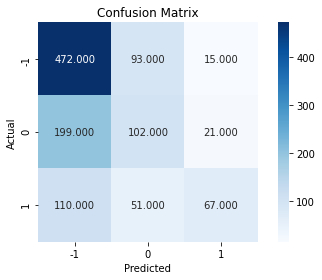

In [1669]:
print(classification_report(y_avg, val_rom_Y))
plot_cm(val_rom_Y, y_avg)

### LogisticRegression

              precision    recall  f1-score   support

          -1       0.64      0.62      0.63       410
           0       0.53      0.54      0.53       386
           1       0.60      0.60      0.60       329

    accuracy                           0.59      1125
   macro avg       0.59      0.59      0.59      1125
weighted avg       0.59      0.59      0.59      1125



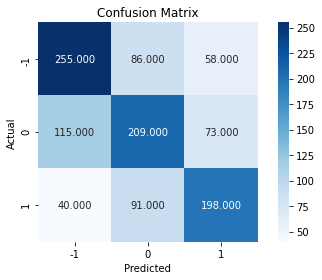

In [1484]:
# Logistic Regression with obama's tweets
pipe_LogReg_o = define_pipe(LogisticRegression(solver='liblinear', max_iter=10000))
pipe_LogReg_o.fit(train_oba_X, train_oba_Y)
y_pred = pipe_LogReg_o.predict(val_oba_X)

print(classification_report(y_pred, val_oba_Y))
plot_cm(val_oba_Y, y_pred)

              precision    recall  f1-score   support

          -1       0.85      0.62      0.72       799
           0       0.30      0.48      0.37       204
           1       0.32      0.57      0.41       127

    accuracy                           0.59      1130
   macro avg       0.49      0.55      0.50      1130
weighted avg       0.69      0.59      0.62      1130



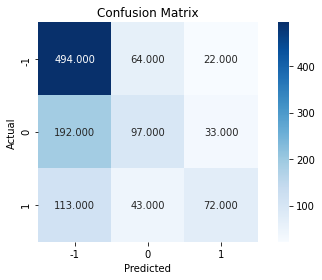

In [1488]:
# Logistic Regression with Romney's tweets
pipe_LogReg_r = define_pipe(LogisticRegression(solver='liblinear', max_iter=10000))
pipe_LogReg_r.fit(train_rom_X, train_rom_Y)
y_pred = pipe_LogReg_r.predict(val_rom_X)

print(classification_report(y_pred, val_rom_Y))
plot_cm(val_rom_Y, y_pred)

              precision    recall  f1-score   support

          -1       0.74      0.59      0.66      1153
           0       0.46      0.54      0.49       651
           1       0.46      0.56      0.50       451

    accuracy                           0.57      2255
   macro avg       0.55      0.57      0.55      2255
weighted avg       0.60      0.57      0.58      2255



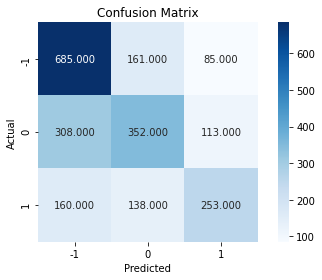

In [1490]:
# Logistic Regression with all data
pipe_LogReg_all = define_pipe(LogisticRegression(max_iter=10000))
pipe_LogReg_all.fit(train_X, train_Y)
y_pred = pipe_LogReg_all.predict(val_X)

print(classification_report(y_pred,val_Y))
plot_cm(val_Y, y_pred)

### RandomForest Classifier

              precision    recall  f1-score   support

          -1       0.62      0.63      0.63       390
           0       0.48      0.54      0.50       353
           1       0.61      0.53      0.57       382

    accuracy                           0.57      1125
   macro avg       0.57      0.57      0.57      1125
weighted avg       0.57      0.57      0.57      1125



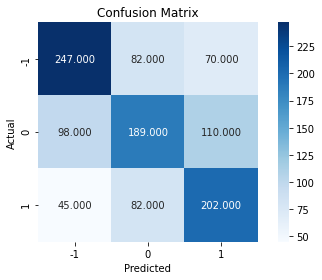

In [1582]:
# RandomForestClassifier with obama data
pipe_rf_o = define_pipe(RandomForestClassifier(n_estimators=500))
pipe_rf_o.fit(train_oba_X, train_oba_Y)
y_pred = pipe_rf_o.predict(val_oba_X)

print(classification_report(y_pred, val_oba_Y))
plot_cm(val_oba_Y, y_pred)

              precision    recall  f1-score   support

          -1       0.86      0.60      0.70       828
           0       0.27      0.46      0.34       188
           1       0.30      0.60      0.40       114

    accuracy                           0.58      1130
   macro avg       0.47      0.55      0.48      1130
weighted avg       0.70      0.58      0.61      1130



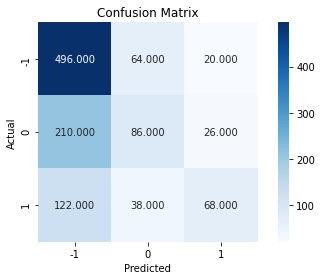

In [1571]:
# RandomForestClassifier Romney data
pipe_rf_r = define_pipe(RandomForestClassifier(criterion="entropy", n_estimators=500))
pipe_rf_r.fit(train_rom_X, train_rom_Y)
y_pred = pipe_rf_r.predict(val_rom_X)
print(classification_report(y_pred, val_rom_Y))
plot_cm(val_rom_Y, y_pred)

              precision    recall  f1-score   support

          -1       0.78      0.56      0.65      1296
           0       0.41      0.56      0.48       567
           1       0.42      0.59      0.49       392

    accuracy                           0.57      2255
   macro avg       0.54      0.57      0.54      2255
weighted avg       0.63      0.57      0.58      2255



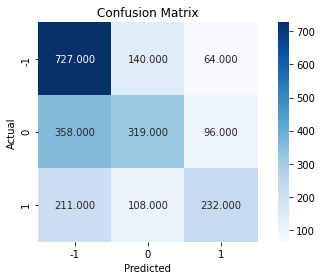

In [1580]:
# RandomForestClassifier all data
pipe_rf_a = define_pipe(RandomForestClassifier())
pipe_rf_a.fit(train_X, train_Y)
y_pred = pipe_rf_a.predict(val_X)
print(classification_report(y_pred, val_Y))
plot_cm(val_Y, y_pred)

### Multinomial NB

MultinomialNB
              precision    recall  f1-score   support

          -1       0.72      0.56      0.63       513
           0       0.51      0.56      0.53       360
           1       0.48      0.62      0.54       252

    accuracy                           0.57      1125
   macro avg       0.57      0.58      0.57      1125
weighted avg       0.60      0.57      0.58      1125



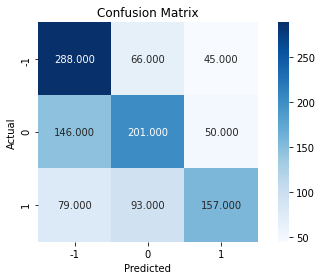

In [1525]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB

X_train_dtm, X_val_dtm = word2vec(train_oba_X, val_oba_X)
mtnb_o = MultinomialNB(alpha = 20)
Y_pred_Bayes = mtnb_o.fit(X_train_dtm.toarray(), train_oba_Y).predict(X_val_dtm.toarray())

print('MultinomialNB')
print(classification_report(Y_pred_Bayes, val_oba_Y))
plot_cm(val_oba_Y, Y_pred_Bayes)

MultinomialNB
              precision    recall  f1-score   support

          -1       0.77      0.64      0.70       693
           0       0.34      0.45      0.39       244
           1       0.43      0.51      0.47       193

    accuracy                           0.58      1130
   macro avg       0.51      0.53      0.52      1130
weighted avg       0.62      0.58      0.59      1130



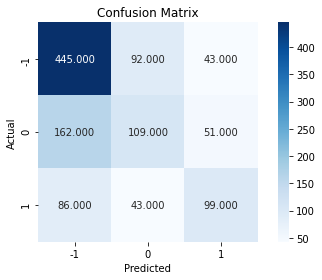

In [1543]:
# Multinomial NB with romney's data
X_train_dtm, X_val_dtm = word2vec(train_rom_X, val_rom_X)

mtnb_r = MultinomialNB(alpha=0.6)
Y_pred_Bayes = mtnb_r.fit(X_train_dtm.toarray(), train_rom_Y).predict(X_val_dtm.toarray())

print('MultinomialNB')
print(classification_report(Y_pred_Bayes, val_rom_Y))
plot_cm(val_rom_Y, Y_pred_Bayes)

MultinomialNB
              precision    recall  f1-score   support

          -1       0.76      0.57      0.65      1239
           0       0.40      0.59      0.47       523
           1       0.48      0.54      0.51       493

    accuracy                           0.57      2255
   macro avg       0.55      0.56      0.54      2255
weighted avg       0.61      0.57      0.58      2255



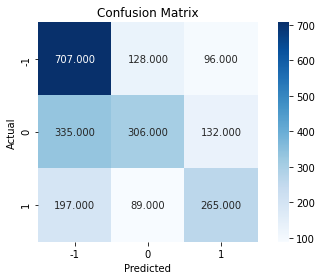

In [1584]:
X_train_dtm, X_val_dtm = word2vec(train_X, val_X)

mtnb_a = MultinomialNB(alpha=2)
Y_pred_Bayes = mtnb_a.fit(X_train_dtm.toarray(), train_Y).predict(X_val_dtm.toarray())

print('MultinomialNB')
print(classification_report(Y_pred_Bayes, val_Y))
plot_cm(val_Y, Y_pred_Bayes)

## Ensemble Model

In [747]:
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn import model_selection

In [1625]:
def ensemble_model1():
    estimators = []
    model1 = LogisticRegression(max_iter=10000)
    estimators.append(('logistic', model1))
    model2 = RandomForestClassifier(n_estimators=100)
    estimators.append(('randf', model2))
    model3 = SVC()
    estimators.append(('svm', model3))
    ensemble_model = VotingClassifier(estimators)
    
    return ensemble_model  

def ensemble_model2():
    estimators = []
    model1 = LogisticRegression(max_iter=10000)
    estimators.append(('logistic', model1))
    model2 = SVC()
    estimators.append(('svm1', model2))
    model3 = SVC()
    estimators.append(('svm2', model3))
    # create the ensemble model
    ensemble_model = VotingClassifier(estimators)
    
    return ensemble_model
    

              precision    recall  f1-score   support

          -1       0.61      0.63      0.62       382
           0       0.49      0.55      0.51       354
           1       0.65      0.55      0.60       389

    accuracy                           0.58      1125
   macro avg       0.58      0.58      0.58      1125
weighted avg       0.58      0.58      0.58      1125



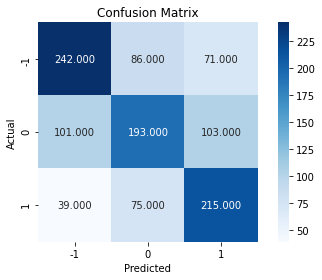

In [1627]:
# LogReg + RandomForest + SVC with obama data
X_train_dtm, X_val_dtm = word2vec(train_oba_X, val_oba_X)

ensemble = ensemble_model1()
ensemble.fit(X_train_dtm, train_oba_Y)
Y_pred = ensemble.predict(X_val_dtm.toarray())

print(classification_report(Y_pred, val_oba_Y))
plot_cm(val_oba_Y, Y_pred)

              precision    recall  f1-score   support

          -1       0.83      0.60      0.69       804
           0       0.30      0.46      0.37       214
           1       0.28      0.57      0.38       112

    accuracy                           0.57      1130
   macro avg       0.47      0.54      0.48      1130
weighted avg       0.67      0.57      0.60      1130



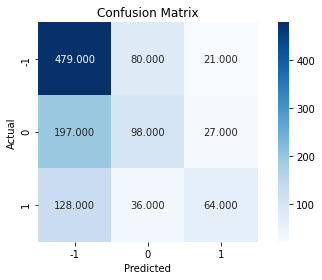

In [1630]:
# LogReg + RandomForest + SVC with romney data
X_train_dtm, X_val_dtm = word2vec(train_rom_X, val_rom_X)

ensemble = ensemble_model1()
ensemble.fit(X_train_dtm, train_rom_Y)
Y_pred = ensemble.predict(X_val_dtm.toarray())

print(classification_report(Y_pred, val_rom_Y))
plot_cm(val_rom_Y, Y_pred)

              precision    recall  f1-score   support

          -1       0.77      0.57      0.66      1240
           0       0.44      0.58      0.50       578
           1       0.47      0.60      0.53       437

    accuracy                           0.58      2255
   macro avg       0.56      0.59      0.56      2255
weighted avg       0.62      0.58      0.59      2255



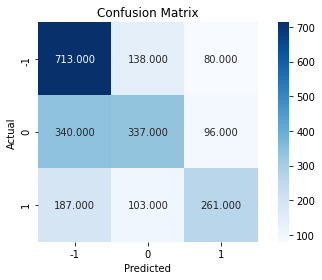

In [1631]:
## LogReg + RandomForest + SVC with all data
X_train_dtm, X_val_dtm = word2vec(train_X, val_X)

ensemble = ensemble_model1()
ensemble.fit(X_train_dtm, train_Y)
Y_pred = ensemble.predict(X_val_dtm.toarray())

print(classification_report(Y_pred, val_Y))
plot_cm(val_Y, Y_pred)

              precision    recall  f1-score   support

          -1       0.61      0.64      0.62       382
           0       0.49      0.55      0.52       351
           1       0.66      0.55      0.60       392

    accuracy                           0.58      1125
   macro avg       0.59      0.58      0.58      1125
weighted avg       0.59      0.58      0.58      1125



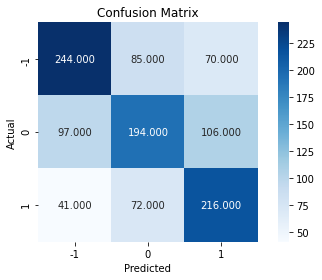

In [1670]:
# LogReg + SVC + SVC with obama data
X_train_dtm, X_val_dtm = word2vec(train_oba_X, val_oba_X)

ensemble = ensemble_model2()
ensemble.fit(X_train_dtm, train_oba_Y)
Y_pred = ensemble.predict(X_val_dtm.toarray())

print(classification_report(Y_pred, val_oba_Y))
plot_cm(val_oba_Y, Y_pred)

              precision    recall  f1-score   support

          -1       0.83      0.60      0.69       806
           0       0.30      0.47      0.37       209
           1       0.28      0.56      0.37       115

    accuracy                           0.57      1130
   macro avg       0.47      0.54      0.48      1130
weighted avg       0.68      0.57      0.60      1130



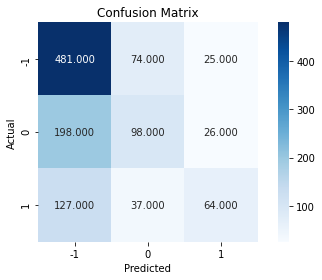

In [1637]:
# LogReg + SVC + SVC with romney data
X_train_dtm, X_val_dtm = word2vec(train_rom_X, val_rom_X)

ensemble = ensemble_model2()
ensemble.fit(X_train_dtm, train_rom_Y)
Y_pred = ensemble.predict(X_val_dtm.toarray())

print(classification_report(Y_pred, val_rom_Y))
plot_cm(val_rom_Y, Y_pred)

              precision    recall  f1-score   support

          -1       0.76      0.57      0.65      1238
           0       0.44      0.58      0.50       587
           1       0.47      0.60      0.53       430

    accuracy                           0.58      2255
   macro avg       0.56      0.58      0.56      2255
weighted avg       0.62      0.58      0.59      2255



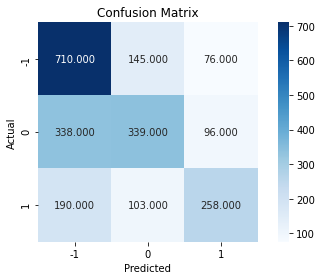

In [1636]:
# LogReg + SVC + SVC with all data
X_train_dtm, X_val_dtm = word2vec(train_X, val_X)

ensemble = ensemble_model2()
ensemble.fit(X_train_dtm, train_Y)
Y_pred = ensemble.predict(X_val_dtm.toarray())

print(classification_report(5Y_pred, val_Y))
plot_cm(val_Y, Y_pred)

## Prediction on Test Data

In [ ]:
def parse_testdata(df):
    
    #drop missing values and rename columns
    df = df.iloc[1:, 3:5]
    df = df.rename(columns = {'Anootated tweet':'Tweet', 'Unnamed: 4': 'Class'})
    # Drop rows if Tweet is empty
    df.dropna(subset = ['Tweet'], inplace=True)
    print(df.shape)
    
    #dtype class label
    df['Class'] = df['Class'].astype(str)
    df['Tweet'] = df['Tweet'].astype(str)
    print(df.info())
    print(df['Class'].value_counts())

    # Extract rows where class labels -1, 0, 1
    df = df[ (df['Class'] == '0') |(df['Class'] == '-1') | (df['Class'] == '1') ]
    print('After extracting:', df.shape)
    
    tweets = df['Tweet'].values
    targets = df['Class'].values
    
    return df

def save_dataset(tweets, targets, tw_name, tar_name, filepath = 'TrainData'):
    print('Saving training dataset...')
    
    #Create Saving Files
    if not os.path.exists(filepath):
        os.makedirs(filepath)
        
    np.save(filepath + '/' + tw_name + '.npy', tweets)
    np.save(filepath + '/'+ tar_name + '.npy', targets)

    print('Saved parsed dataset')
    

In [1748]:
# Preprocess Test Dataset
# Load dataset from .csv

xls_oba = pd.read_excel('final-testData-no-label-Obama-tweets.xlsx', index_col=None, header=None)
xls_rom = pd.read_excel('final-testData-no-label-Romney-tweets.xlsx', index_col=None, header=None)

In [1749]:
xls_oba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1951 entries, 0 to 1950
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       1951 non-null   int64 
 1   1       1951 non-null   object
dtypes: int64(1), object(1)
memory usage: 30.6+ KB


In [1750]:
xls_rom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1900 entries, 0 to 1899
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       1900 non-null   int64 
 1   1       1900 non-null   object
dtypes: int64(1), object(1)
memory usage: 29.8+ KB


In [1751]:
print(xls_oba.isnull().sum())
xls_oba = xls_oba.rename(columns = {1:'Tweet', 0: 'Index'})
xls_oba.head()
print(xls_rom.isnull().sum())
xls_rom = xls_rom.rename(columns = {1:'Tweet', 0: 'Index'})
xls_rom.head()

0    0
1    0
dtype: int64
0    0
1    0
dtype: int64


,Index,Tweet
0,1,<e>Romney</e> got 3 less minutes and had to de...
1,2,<e>Mitt </e>is beating him UP! on his record...
2,3,I actually like <e>Romney </e>'s response to ...
3,4,Just for that <a>immigration statement </a>tha...
4,5,This man <e>Romney </e>is tearing this dude ...


In [1752]:
test_oba = xls_oba['Tweet'].astype(str)
test_rom = xls_rom['Tweet'].astype(str)
test_oba[:10], test_rom[:10]

(0    <e>Obama</e> has to maintain his professionali...
 1    <e>Obama</e> went into the debate swinging and...
 2    Ditto. I started @247LS 4 years ago. RT @bmorr...
 3    I absolutely love <e>Obama</e>'s view in <a>im...
 4    I'm agreeing completely with <e>Obama</e>'s st...
 5          <e>Obama</e>'s <a>smile</a> makes me happy.
 6    Hahahahahaahahha<e> Obama</e>'s <a>rebuttal</a...
 7    If you think the economy has gotten worse duri...
 8    <e>Obama</e>'s <a>debate performance</a> tonig...
 9    I like the fact that it's not within <e>Obama<...
 Name: Tweet, dtype: object,
 0    <e>Romney</e> got 3 less minutes and had to de...
 1    <e>Mitt  </e>is beating him UP!  on his record...
 2    I actually like  <e>Romney </e>'s response to ...
 3    Just for that <a>immigration statement </a>tha...
 4    This man  <e>Romney  </e>is tearing this dude ...
 5    <e>Romney  </e>had less to prove, given the la...
 6    <e>Romney </e>- he comes off as a dumbass, but...
 7    Great <a>clos

In [1753]:
test_oba = tweet_cleaning(test_oba, 'all')
test_rom = tweet_cleaning(test_rom, 'all')
test_oba[:10], test_rom[:10]

(0    obama ha maintain hi profession throughout thi...
 1    obama went debat swing came bang good job pres...
 2    ditto start year ago rt work small busi start ...
 3    absolut love obama view immigr realli tri symp...
 4    im agre complet obama stanc immigr let go crim...
 5                               obama smile make happi
 6    hahahahahaahahha obama rebutt got actual crowd...
 7    think economi ha gotten wors dure obama term p...
 8       obama debat perform tonight x better first one
 9             like fact within obama comfort zone rude
 Name: Tweet, dtype: object,
 0    romney got less minut debat candi crowley stil...
 1                  mitt beat hi record credibl charact
 2                    actual like romney respons immigr
 3    immigr statement romney answer wa wa enough ge...
 4                  thi man romney tear thi dude econom
 5    romney less prove given last debat didnt back ...
 6    romney come dumbass love hi plan small larg bu...
 7               gr

In [1755]:
#Create Saving Files
filepath = 'TestData'
if not os.path.exists(filepath):
    os.makedirs(filepath)
        
np.save(filepath + '/test_oba.npy', test_oba)
np.save(filepath + '/test_rom.npy', test_rom)

In [1761]:
import pickle
filename = 'finalized_oba_SVC.sav'
pickle.dump(pipe_SVC_o, open(filename, 'wb'))

filename = 'finalized_rom_SVC.sav'
pickle.dump(pipe_SVC_r, open(filename, 'wb')) 


In [1762]:
# load the model from disk
loaded_oba = pickle.load(open('finalized_oba_SVC.sav', 'rb'))
loaded_rom = pickle.load(open('finalized_rom_SVC.sav', 'rb'))

In [1770]:
y_pred_testo = loaded_oba.predict(test_oba)
y_pred_testr = loaded_oba.predict(test_rom)

y_pred_testo.shape, y_pred_testr.shape

((1951,), (1900,))

In [1771]:
y_pred_testo

array(['1', '1', '-1', ..., '1', '-1', '-1'], dtype=object)

In [1772]:
# Save results
with open('obama_SVC.txt', 'w') as f:
    for index, pred in enumerate(y_pred_testo):
        f.write("{};;{}\n".format(index+1, pred))
f.close()

In [1773]:
with open('romney_SVC.txt', 'w') as f:
    for index, pred in enumerate(y_pred_testr):
        f.write("{};;{}\n".format(index+1, pred))
f.close()

In [1774]:
np.save(filepath + '/SVC_oba_result.npy', y_pred_testo)
np.save(filepath + '/SVC_rom_result.npy', y_pred_testr)

In [1806]:
bert_rom= np.load('BERT_rom_result.npy', allow_pickle=True)
bert = np.load('BERT_oba_result.npy', allow_pickle=True)